# Modules

In [182]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import torch
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

from torch.optim import Adam
from torch.utils.data import DataLoader

from tqdm.autonotebook import tqdm

from scarf.model import Neural_Net
from dataset_samplers import RandomCorruptSampler, ClassCorruptSampler 
from utils import fix_seed, load_openml_list, preprocess_datasets, fit_one_hot_encoder


seed = 1234
fix_seed(seed)

clf = LogisticRegression()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [275]:
# Toy dataset
dataset_name = 'breast_cancer'
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]

# OpenML dataset
#datasets = load_openml_list([6, 6332])
# select one dataset to run below
#dataset = datasets[1]
#dataset_name, data, target = dataset
print(f"Loaded dataset: {dataset_name}, with data shape: {data.shape}, and target shape: {target.shape}")

Loaded dataset: breast_cancer, with data shape: (569, 30), and target shape: (569,)


In [276]:
tmp_data, test_data, tmp_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

train_data, valid_data, train_target, valid_target = train_test_split(
    tmp_data,
    tmp_target,
    test_size=1/7,
    stratify=tmp_target,
    random_state=seed
)

print(f"# samples: Train: {len(train_data)}; Valid: {len(valid_data)}; Test: {len(test_data)}")
print(f"Train data with type {type(train_data)} and shape {train_data.shape}; Train target with type: {type(train_target)} and shape {train_target.shape}")
print(f"Valid data with type {type(valid_data)} and shape {valid_data.shape}; Valid target with type: {type(valid_target)} and shape {valid_target.shape}")
print(f"Test data with type {type(test_data)} and shape {test_data.shape}; Test target with type: {type(test_target)} and shape {test_target.shape}")


# samples: Train: 390; Valid: 65; Test: 114
Train data with type <class 'pandas.core.frame.DataFrame'> and shape (390, 30); Train target with type: <class 'pandas.core.series.Series'> and shape (390,)
Valid data with type <class 'pandas.core.frame.DataFrame'> and shape (65, 30); Valid target with type: <class 'pandas.core.series.Series'> and shape (65,)
Test data with type <class 'pandas.core.frame.DataFrame'> and shape (114, 30); Test target with type: <class 'pandas.core.series.Series'> and shape (114,)


In [277]:
preprocess_datasets(train_data, valid_data, test_data, normalize_numerical_features=True)
one_hot_encoder = fit_one_hot_encoder(preprocessing.OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False), train_data)

train_data.head()

one_hot_encoder_target = preprocessing.OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False)
one_hot_encoder_target.fit(np.array(train_target, dtype='object').reshape(-1,1))

# convert targets to binary values here already, since no need to worry about corrupting one-hot encoding for targets
# first convert targets to a numpy column array
train_target = one_hot_encoder_target.transform(np.array(train_target, dtype='object').reshape(-1,1))
test_target = one_hot_encoder_target.transform(np.array(test_target, dtype='object').reshape(-1,1))

# convert targets to a row numpy array
train_target, test_target = np.squeeze(train_target), np.squeeze(test_target)

Data preprocess finished! Dropped 0 features. Normalized numerical features.


/home/wei/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [278]:
fraction_withLabel = 0.25
n_train_samples_labeled = int(len(train_data)*fraction_withLabel)
# shouldn't index using this variable as it shuffles the ordering
idxes_tmp = np.random.permutation(len(train_data))[:n_train_samples_labeled]
mask_train_labeled = np.zeros_like(train_target, dtype=bool)
mask_train_labeled[idxes_tmp] = True

print(f"Under semi-supervised learning, assume {n_train_samples_labeled}/{len(train_data)} training samples are labeled.")

Under semi-supervised learning, assume 97/390 training samples are labeled.


In [279]:
batch_size = 128

train_data_samplers = {}

# Random Sampling
train_data_samplers['rand_corr'] = RandomCorruptSampler(train_data, batch_size) # not using class information in original corruption

# Oracle Class Sampling
train_data_samplers['orc_corr'] = ClassCorruptSampler(train_data, batch_size, train_target) # oracle info on training labels

# Predicted Class Sampling
# Use a fraction of labeled samples
print("Fitting to the labeled set for pseudo labeling...")

clf.fit(one_hot_encoder.transform(train_data)[mask_train_labeled], train_target[mask_train_labeled])
train_predictions = clf.predict(one_hot_encoder.transform(train_data))

train_data_samplers['cls_corr'] = ClassCorruptSampler(train_data, batch_size, \
    np.where(mask_train_labeled, train_target, train_predictions) # bootstrapped training labels
)

Fitting to the labeled set for pseudo labeling...


In [280]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models, optimizers, loss_histories = {}, {}, {}
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    models[key] = Neural_Net(
        input_dim=one_hot_encoder.transform(train_data).shape[1],  # model expect one-hot encoded input
        emb_dim=16,
        corruption_rate=0.6,
        model_device=device
    ).to(device)
    optimizers[key] = Adam(models[key].parameters(), lr=0.001)
    loss_histories[key] = []

Created a model with input dimension: 30
Created a model with input dimension: 30
Created a model with input dimension: 30


# Training

In [281]:
epochs = 4_500

for epoch in tqdm(range(1, epochs + 1)):
    for key in ['rand_corr', 'cls_corr', 'orc_corr']:
        epoch_loss = models[key].train_epoch(train_data_samplers[key], optimizers[key], one_hot_encoder)
        loss_histories[key].append(epoch_loss)

# save the models and losses
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    torch.save(models[key].state_dict(), model_filename)
    print(f"Model saved at {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_losses.npy"
    np.save(loss_filename, loss_histories[key])
    print(f"Model losses saved at {loss_filename}!")

  0%|          | 0/4500 [00:00<?, ?it/s]

Model saved at trained_models/breast_cancer_rand_corr.pt!
Model losses saved at trained_models/breast_cancer_rand_corr_losses.npy!
Model saved at trained_models/breast_cancer_cls_corr.pt!
Model losses saved at trained_models/breast_cancer_cls_corr_losses.npy!
Model saved at trained_models/breast_cancer_orc_corr.pt!
Model losses saved at trained_models/breast_cancer_orc_corr_losses.npy!


# [Optional] Load previously trained models and their losses

In [40]:
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    models[key].load_state_dict(torch.load(model_filename))
    print(f"Model loaded from {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_losses.npy"
    loss_histories[key] = np.load(loss_filename)
    print(f"Model losses loaded from {loss_filename}!")

Model loaded from trained_models/breast_cancer_rand_corr.pt!
Model losses loaded from trained_models/breast_cancer_rand_corr_losses.npy!
Model loaded from trained_models/breast_cancer_cls_corr.pt!
Model losses loaded from trained_models/breast_cancer_cls_corr_losses.npy!
Model loaded from trained_models/breast_cancer_orc_corr.pt!
Model losses loaded from trained_models/breast_cancer_orc_corr_losses.npy!


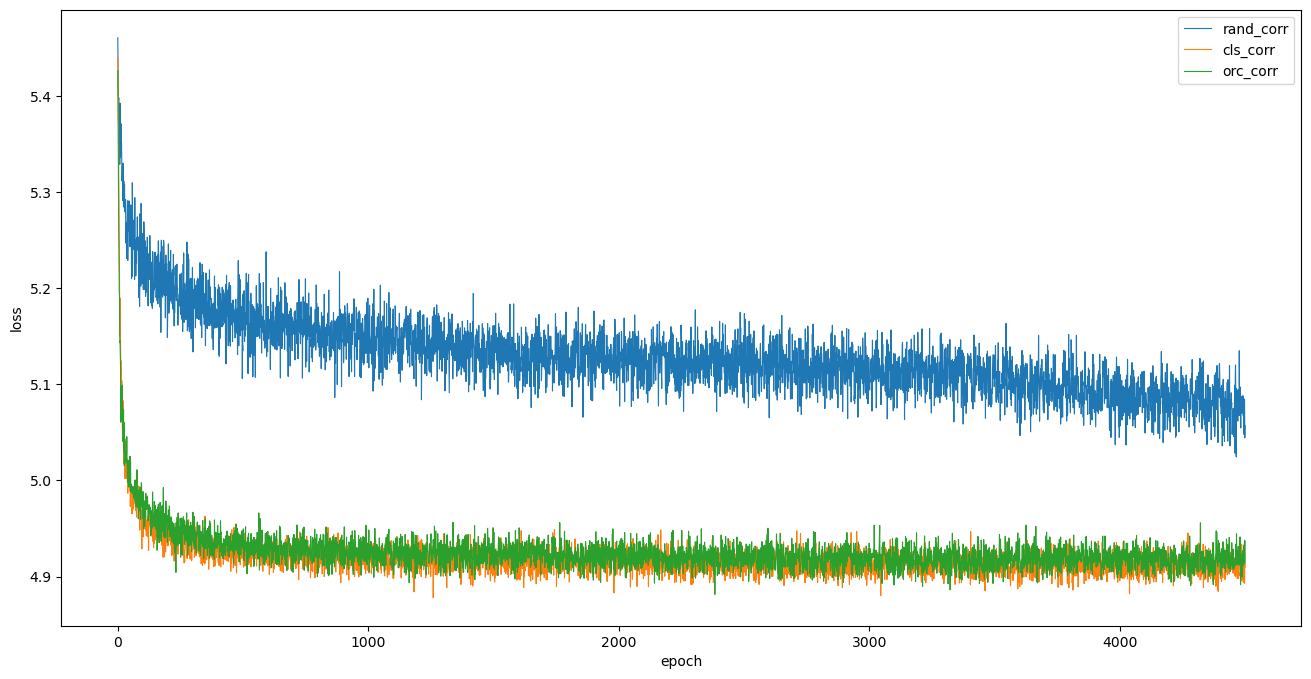

In [282]:
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(loss_histories[key], label=key, linewidth=0.8)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

# Evaluate embeddings

In [284]:
# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    train_embeddings[key] = models[key].get_dataset_embedding(train_data, one_hot_encoder)
    test_embeddings[key] = models[key].get_dataset_embedding(test_data, one_hot_encoder)

In [285]:
# Supervised learning baseline: train the classifier on the fractionally labeled original data
clf.fit(one_hot_encoder.transform(train_data.iloc[mask_train_labeled]), train_target[mask_train_labeled])
test_predictions = clf.predict(one_hot_encoder.transform(test_data))
print("Classification report for direct fitting inputs:")
print(classification_report(test_target, test_predictions))


# embeddings dataset: train the classifier on the embeddings
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    clf.fit(train_embeddings[key][mask_train_labeled], train_target[mask_train_labeled])
    test_predictions = clf.predict(test_embeddings[key])
    print(f"Classification report using {key} embeddings:")
    print(classification_report(test_target, test_predictions))

Classification report for direct fitting inputs:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        42
         1.0       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Classification report using rand_corr embeddings:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        42
         1.0       0.99      1.00      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Classification report using cls_corr embeddings:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        42
         1.0       0.95      1.00      0.97        72

    accuracy                      

# Visualzie using t-sne 

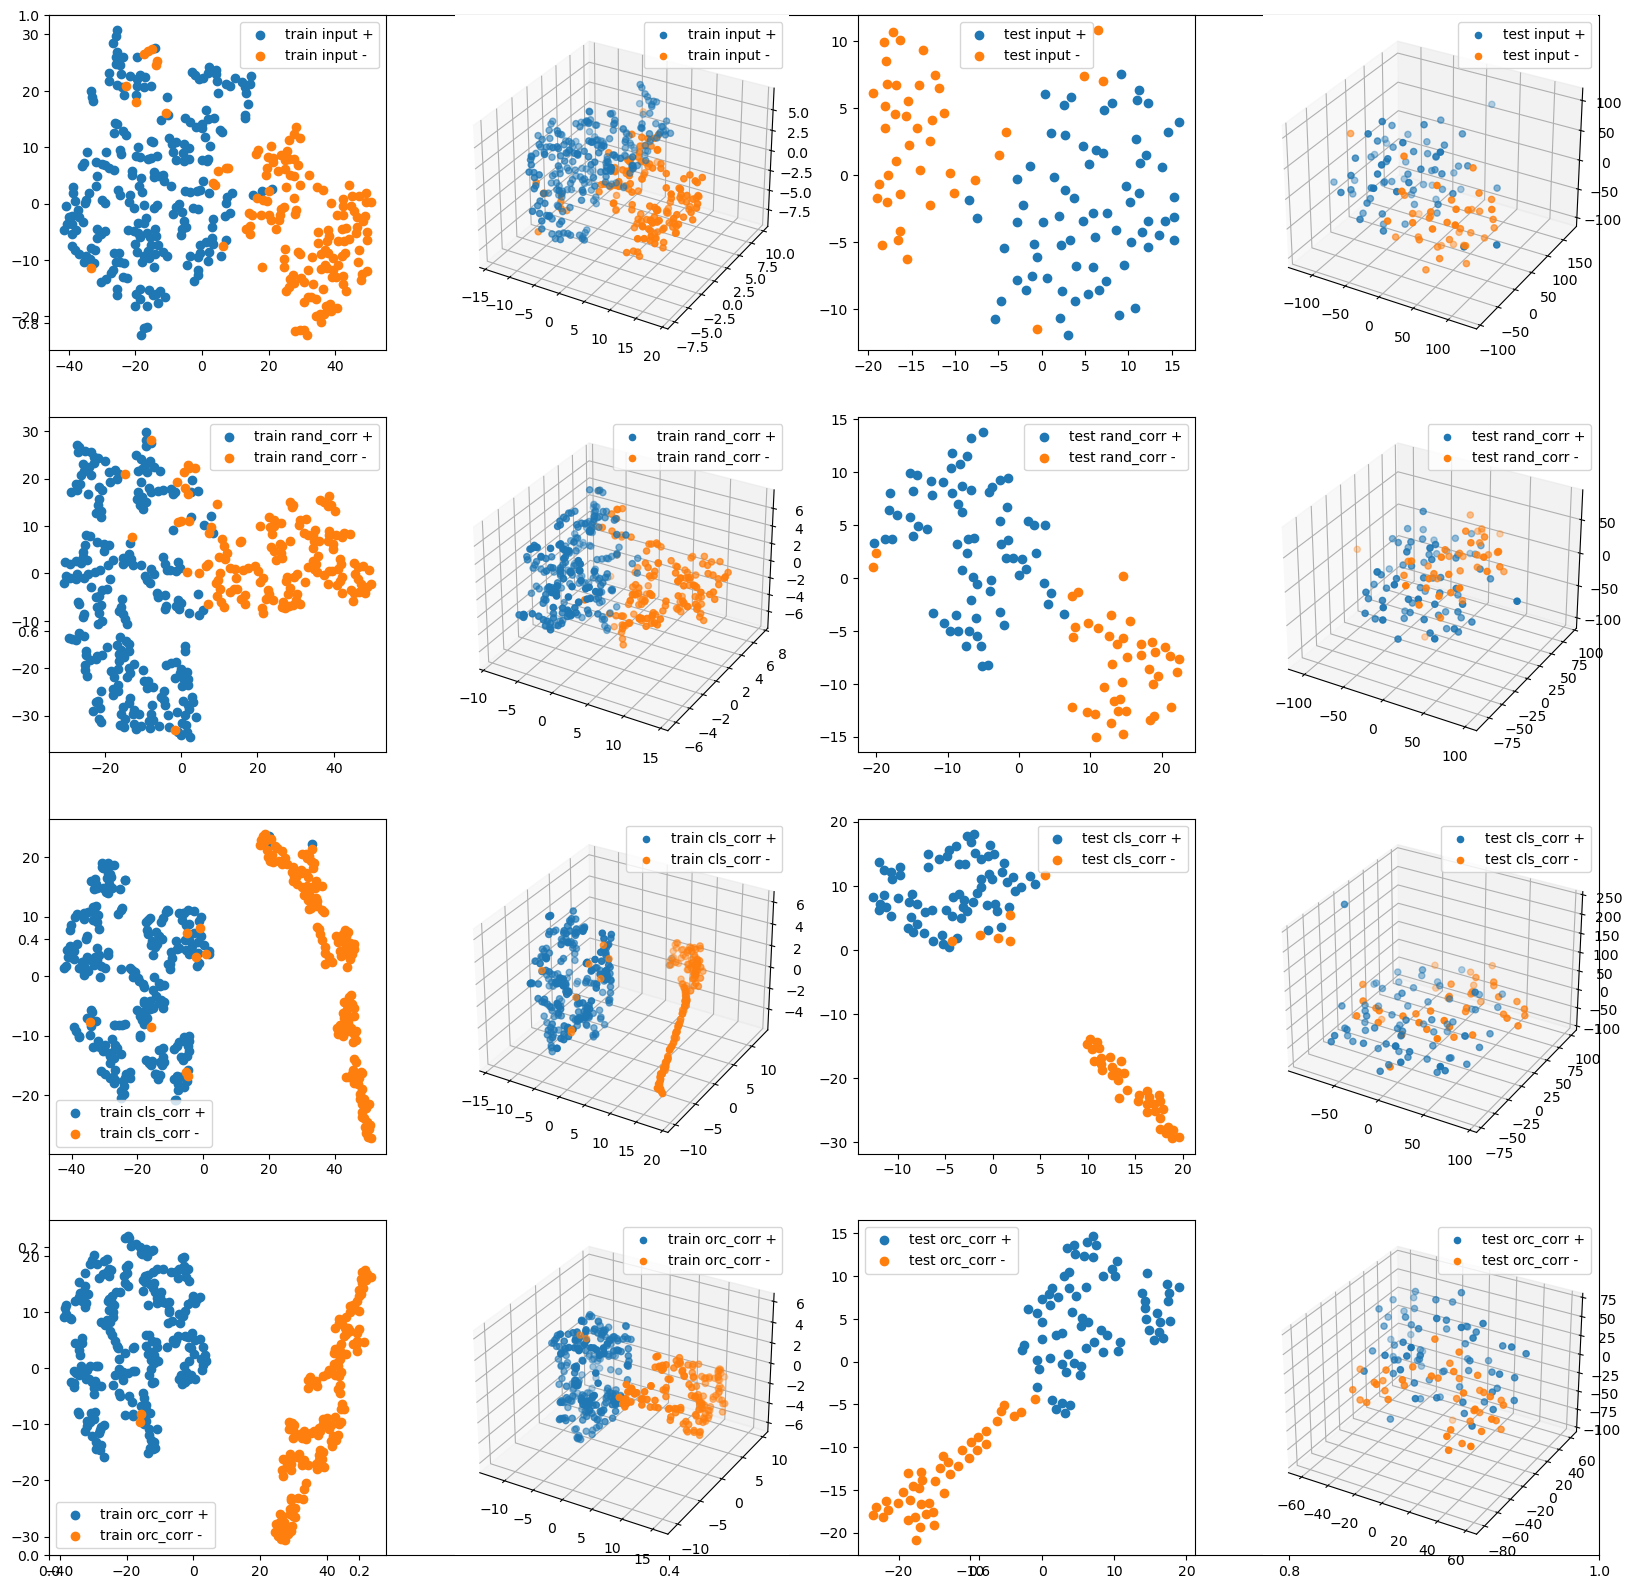

In [286]:
# visualize in 2D
fig, axes = plt.subplots(figsize=(20, 20))

tsne_2D = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
tsne_3D = TSNE(n_components=3, learning_rate="auto", init="pca", perplexity=15)
# first plot the original input
reduced_2D = tsne_2D.fit_transform(one_hot_encoder.transform(train_data))
reduced_3D = tsne_3D.fit_transform(one_hot_encoder.transform(train_data))
positive = train_target == 1
ax = fig.add_subplot(4,4,1)
ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train input +")
ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train input -")
ax.legend()
ax = fig.add_subplot(4,4,2, projection='3d')
ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train input +")
ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train input -")
ax.legend()
reduced_2D = tsne_2D.fit_transform(one_hot_encoder.transform(test_data))
reduced_3D = tsne_3D.fit_transform(one_hot_encoder.transform(test_data))
positive = test_target == 1
ax = fig.add_subplot(4,4,3)
ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label="test input +")
ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label="test input -")
ax.legend()
ax = fig.add_subplot(4,4,4, projection='3d')
ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label="test input +")
ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label="test input -")
ax.legend()


for row_id, key in enumerate(['rand_corr', 'cls_corr', 'orc_corr']):
    reduced_2D = tsne_2D.fit_transform(train_embeddings[key])
    reduced_3D = tsne_3D.fit_transform(train_embeddings[key])
    positive = train_target == 1
    ax = fig.add_subplot(4,4,(row_id+1)*4+1)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,(row_id+1)*4+2, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train {key} -")
    ax.legend()

    reduced_2D = tsne_2D.fit_transform(test_embeddings[key])
    reduced_3D = tsne_3D.fit_transform(test_embeddings[key])
    positive = test_target == 1
    ax = fig.add_subplot(4,4,(row_id+1)*4+3)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"test {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"test {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,(row_id+1)*4+4, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"test {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"test {key} -")
    ax.legend()

plt.show()